In [1]:
import rpy2.robjects as ro
from rpy2.robjects import numpy2ri

# Activer la conversion automatique entre les arrays R et numpy
numpy2ri.activate()

In [2]:
# GLOBAL_ENSEMBLE.RData are the RData fro CEPHALOPOD that represent FGs biomass distribution 

#carbonmass= '/net/meso/work/svivier/pipeline/Bluecloud_WB_local/output/CarbonMassFG_noPCR/GLOBAL_ENSEMBLE.RData'

ro.r.load('/net/meso/work/svivier/pipeline/Bluecloud_WB_local/output/CarbonMassFG_noPCR/GLOBAL_ENSEMBLE.RData')

print(ro.r.ls())

['all_ens']


In [3]:
data = ro.r['all_ens']

# Vérifier les dimensions
print(data.shape)  

(64800, 9, 5, 12)


In [4]:
import numpy as np

# Données en forme (64800, 8, 10, 12) pour (lon*lat, groupes fonctionnels, bootstrap, mois)
lat_dim = 360
lon_dim = 180
structured_data = data.reshape((lon_dim, lat_dim, 9, 5, 12)) # change if data.shape is different

# Calculer la moyenne sur tous les mois pour chaque groupe fonctionnel et chaque profondeur
yearly_avg = np.mean(structured_data, axis=4)  # Moyenne le long de l'axe des mois


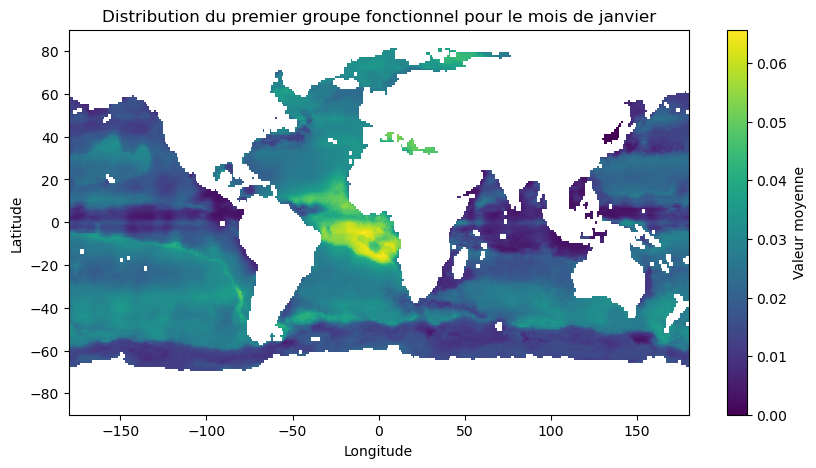

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Supposons que 'data' est votre array 4D chargé, avec la forme (64800, 8, 10, 12)
# Restructuration hypothétique en 2D pour la visualisation
lat_dim = 360
lon_dim = 180
structured_data = data.reshape((lon_dim, lat_dim, 9, 5, 12))

# Sélectionner le premier groupe fonctionnel et le premier mois
selected_data = structured_data[:, :, 2, :, 0]  # premier groupe, premier mois

# Moyenne sur la troisième dimension (bootstrap)
mean_selected_data = np.mean(selected_data, axis=2)

# Définir les valeurs des axes de latitude et de longitude
latitude_values = np.linspace(-90, 90, lat_dim)
longitude_values = np.linspace(-180, 180, lon_dim)

# Visualisation avec matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(mean_selected_data, cmap='viridis', aspect='auto', extent=[-180, 180, -90, 90])
plt.colorbar(label='Valeur moyenne')
plt.title('Distribution du premier groupe fonctionnel pour le mois de janvier')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()



In [6]:
import numpy as np

# Définir les valeurs des axes de latitude et de longitude
latitude_values = np.linspace(-90, 90, lat_dim)
longitude_values = np.linspace(-180, 180, lon_dim)

# Ajuster les valeurs pour qu'elles soient dans la plage souhaitée
latitude_values = np.clip(latitude_values, -90, 90)
longitude_values = np.clip(longitude_values, -180, 180)


In [7]:
mean_annual_data = np.nanmean(data, axis=(2, 3))

/tmp/ipykernel_41361/1641912678.py:1: RuntimeWarning: Mean of empty slice
  mean_annual_data = np.nanmean(data, axis=(2, 3))


In [8]:
import numpy as np
import pandas as pd

# Supposons que mean_annual_data est votre tableau numpy de dimensions (64800, 9)
# mean_annual_data = np.random.rand(64800, 9)  # Exemple de données

# Générer les valeurs de latitude et longitude pour une grille 1°x1°
latitude = np.repeat(np.linspace(-89.5, 89.5, 180), 360)
longitude = np.tile(np.linspace(-179.5, 179.5, 360), 180)

# Préparation des autres colonnes pour le DataFrame
fg_initial_values = np.array([1, 10, 2, 3, 5, 6, 7, 8, 9])
size_initial_values = np.array([1.10, 1.10, 0.8, 2.61, 4.58, 6.8, 1.8, 3.40, 2.76])

# Créer un DataFrame vide
df = pd.DataFrame()

# Boucler sur chaque FG pour créer les lignes du DataFrame
for i, fg in enumerate(fg_initial_values):
    df_fg = pd.DataFrame({
        'Latitude': latitude,
        'Longitude': longitude,
        'FG': fg,
        'Value': mean_annual_data[:, i],
        'Size': size_initial_values[i]
    })
    df = pd.concat([df, df_fg], ignore_index=True)

df['Latitude'] = -df['Latitude']

# Affichage du DataFrame résultant
df


Latitude  Longitude  FG  Value  Size
0           89.5     -179.5   1    NaN  1.10
1           89.5     -178.5   1    NaN  1.10
2           89.5     -177.5   1    NaN  1.10
3           89.5     -176.5   1    NaN  1.10
4           89.5     -175.5   1    NaN  1.10
...          ...        ...  ..    ...   ...
583195     -89.5      175.5   9    NaN  2.76
583196     -89.5      176.5   9    NaN  2.76
583197     -89.5      177.5   9    NaN  2.76
583198     -89.5      178.5   9    NaN  2.76
583199     -89.5      179.5   9    NaN  2.76

[583200 rows x 5 columns]

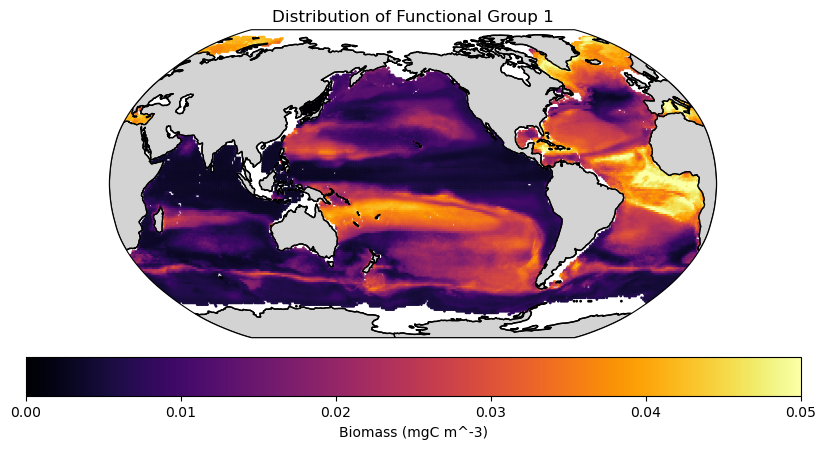

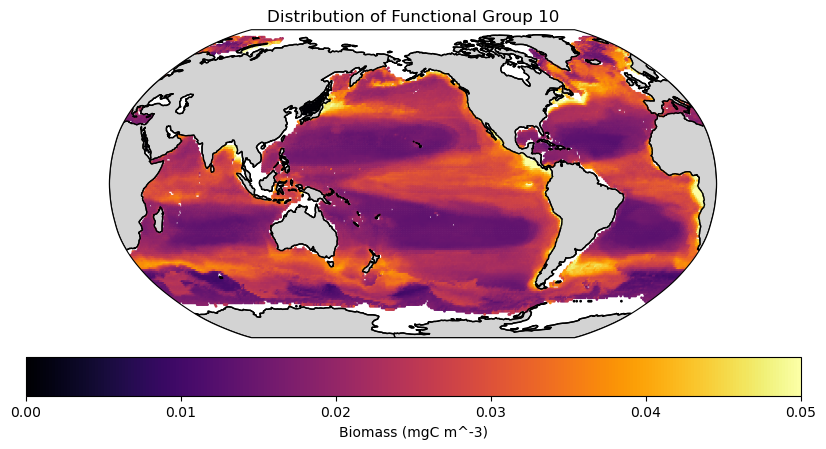

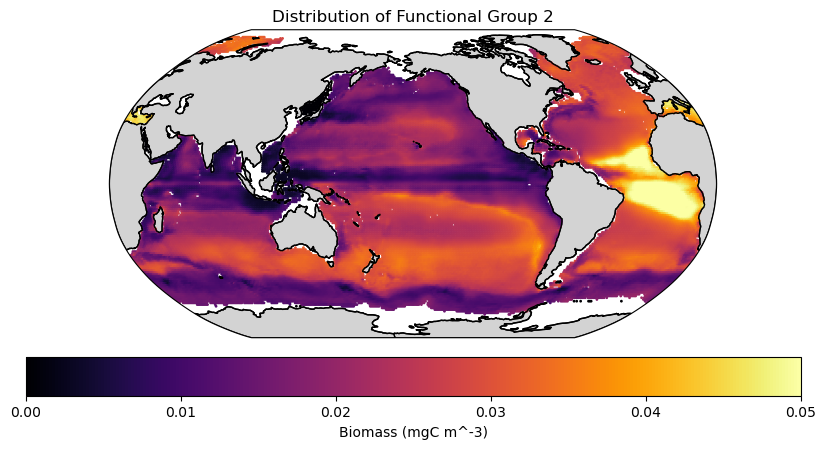

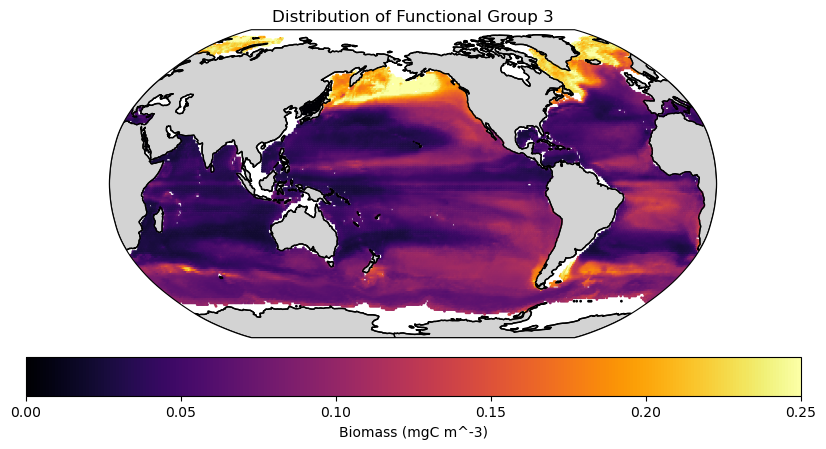

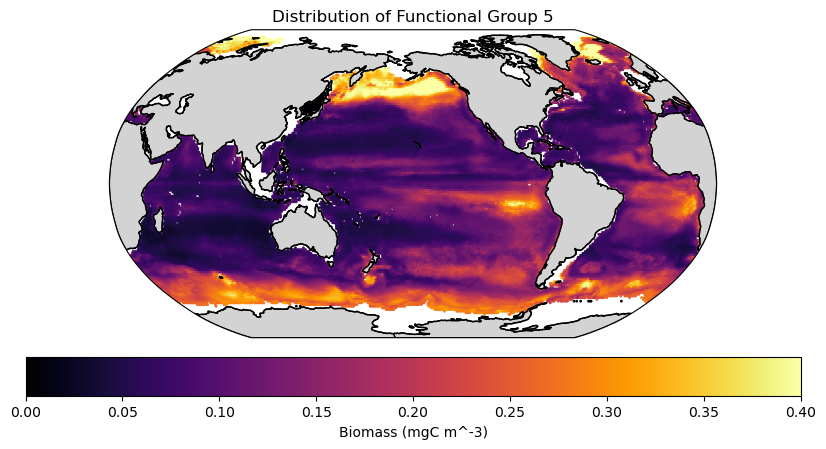

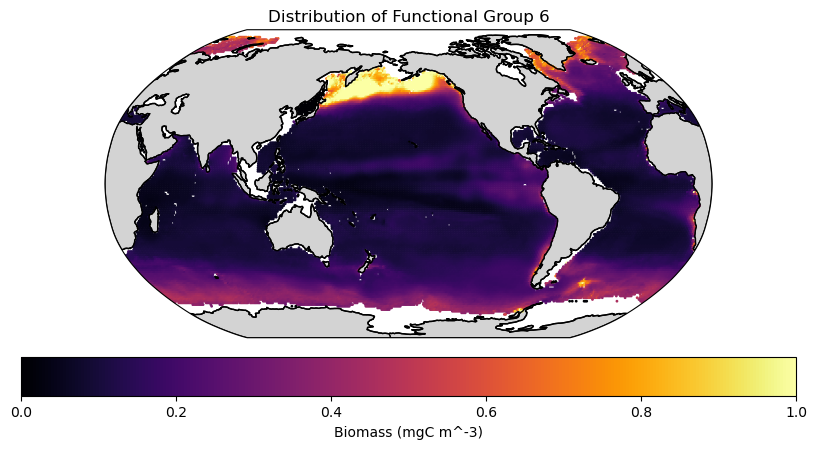

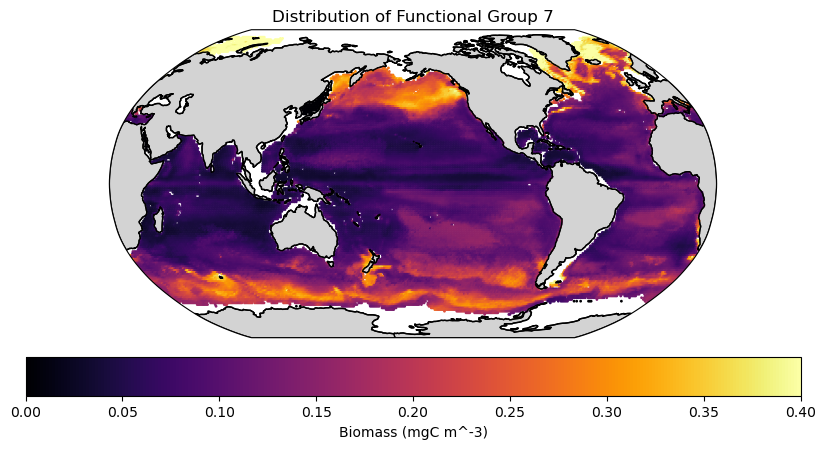

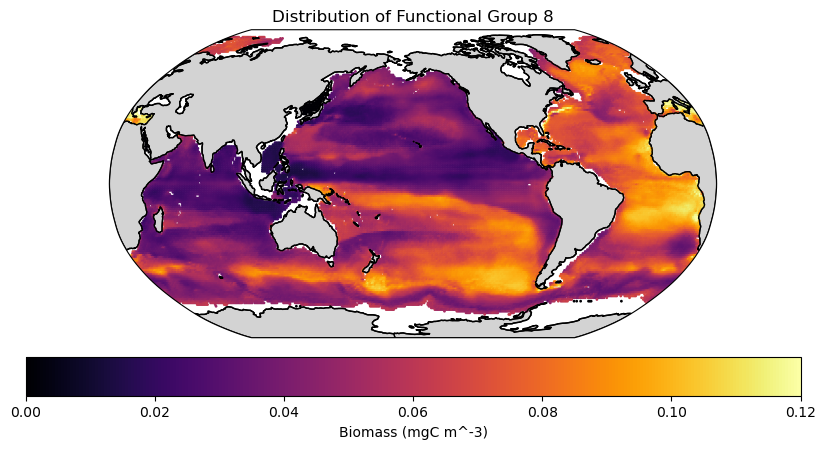

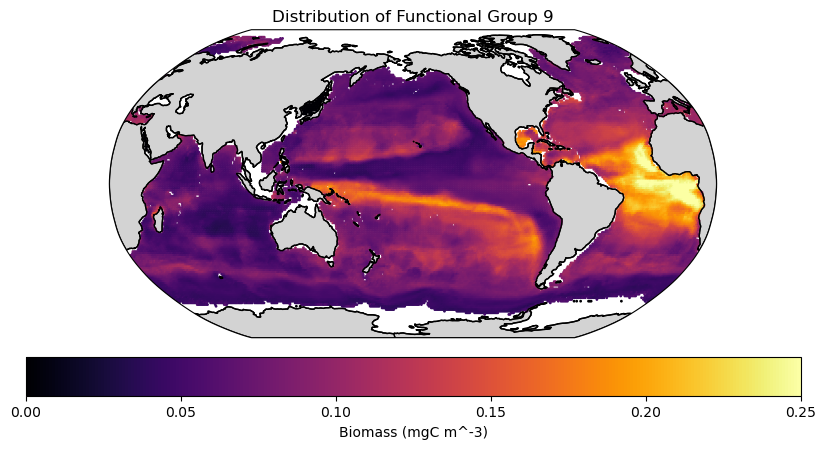

In [10]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import matplotlib.colors as colors
import copy  # Import pour copier la colormap

# Mapping direct des valeurs vmin et vmax à chaque groupe fonctionnel
vmin_map = {1: 0, 10: 0,   2: 0, 3: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}
vmax_map = {1: 0.05, 10: 0.05,   2: 0.05, 3: 0.25, 5: 0.4, 6: 1, 7: 0.4, 8: 0.12, 9: 0.25}

# Boucler sur chaque groupe fonctionnel unique dans le DataFrame
for fg in df['FG'].unique():
    # Sélectionner les données pour le groupe fonctionnel actuel
    data_subset = df[df['FG'] == fg]

    # Créer la carte avec Cartopy en utilisant la projection de Robinson centrée sur -160
    plt.figure(figsize=(10, 5))
    ax = plt.axes(projection=ccrs.Robinson(central_longitude=-160))
    ax.set_global()

    # Ajouter les terres et les côtes
    ax.add_feature(cfeature.LAND, facecolor='lightgray', edgecolor='black')
    ax.add_feature(cfeature.COASTLINE, edgecolor='black')

    # Tracer les données, inversant les valeurs de latitude ici
    scatter = ax.scatter(data_subset['Longitude'], data_subset['Latitude'], c=data_subset['Value'],
                         cmap='inferno', s=1,
                         vmin=vmin_map[fg], vmax=vmax_map[fg],
                         transform=ccrs.PlateCarree())

    # Ajouter une barre de couleur
    cbar = plt.colorbar(scatter, orientation='horizontal', pad=0.05)
    cbar.set_label('Biomass (mgC m^-3)')

    # Affichage du titre
    plt.title(f'Distribution of Functional Group {fg}')

    plt.show()

In [11]:
# Regrouper les données par Latitude et Longitude et calculer la somme de la biomasse pour tous les FG
total_biomass = df.groupby(['Latitude', 'Longitude']).agg({'Value': 'sum'}).reset_index()

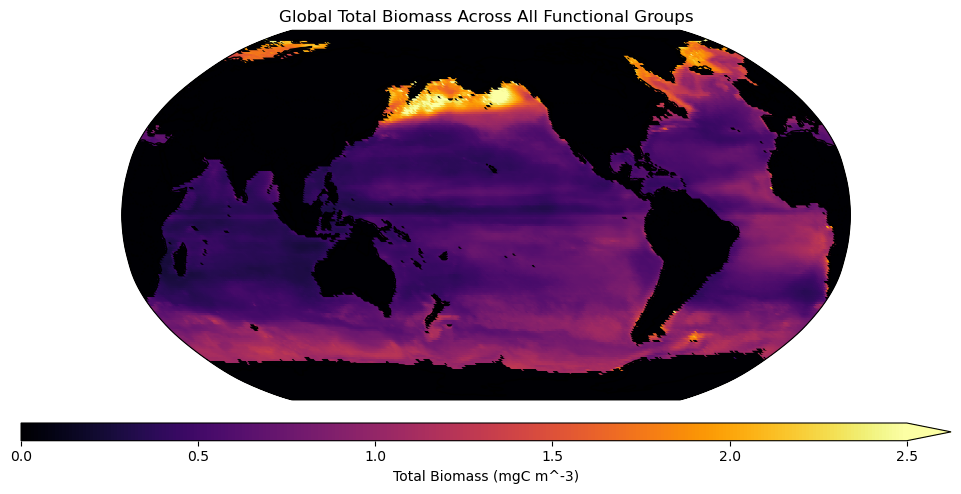

In [12]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import matplotlib.colors as colors
import copy  # Import pour copier la colormap

# Création de la figure et sélection de la projection
plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.Robinson(central_longitude=-160))
ax.set_global()

# Ajout des caractéristiques de la carte
ax.add_feature(cfeature.LAND, facecolor='white')
ax.add_feature(cfeature.OCEAN, facecolor='white')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Copier et définir la colormap, gestion des valeurs NaN
original_cmap = plt.get_cmap('inferno')
cmap = copy.copy(original_cmap)
cmap.set_bad('white')

# Préparer les données, en s'assurant que les NaNs sont gérés correctement
values = total_biomass['Value']
norm = colors.Normalize(vmin=0, vmax=2.5)

# Assurez-vous que les NaN sont bien gérés
np_values = np.ma.array(values, mask=np.isnan(values))

# Tracé des données de biomasse totale
scatter = ax.scatter(total_biomass['Longitude'], total_biomass['Latitude'],
                     c=np_values, s=10,
                     cmap=cmap, norm=norm, transform=ccrs.PlateCarree())

# Ajout d'une barre de couleur
cbar = plt.colorbar(scatter, orientation='horizontal', pad=0.05, aspect=50, extend='max')
cbar.set_label('Total Biomass (mgC m^-3)')

# Titre de la carte
plt.title('Global Total Biomass Across All Functional Groups')

# Affichage de la carte
plt.show()


In [13]:
import pandas as pd
import numpy as np

# Groupe par latitude et longitude et calcule la taille moyenne pondérée par la biomasse
grouped = df.groupby(['Latitude', 'Longitude'])
weighted_size_global = grouped.apply(
    lambda x: np.sum(x['Value'] * x['Size']) / np.sum(x['Value'])
).reset_index(name='Weighted_Size')

/tmp/ipykernel_41361/1522288015.py:7: RuntimeWarning: invalid value encountered in double_scalars
  lambda x: np.sum(x['Value'] * x['Size']) / np.sum(x['Value'])


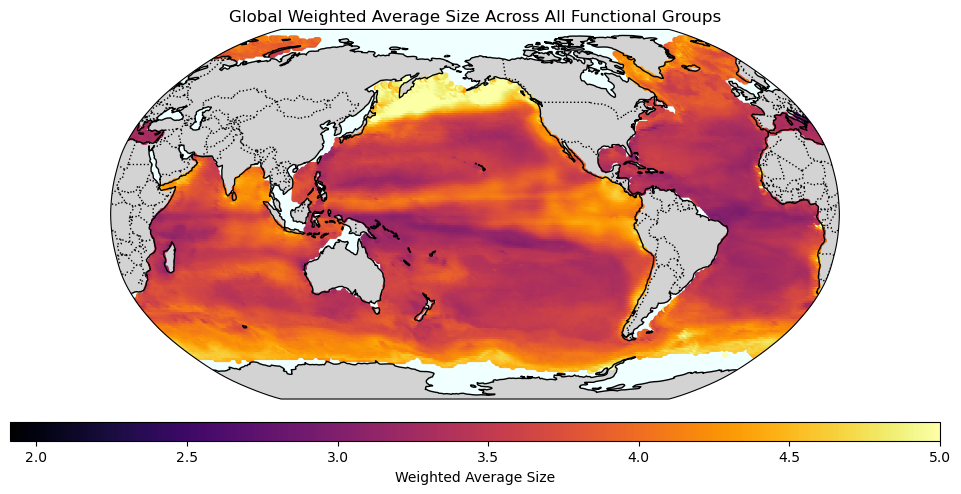

In [14]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Création de la figure et sélection de la projection
plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.Robinson(central_longitude=-160))
ax.set_global()

# Ajout des caractéristiques de la carte
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='azure')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Tracé des données de taille moyenne pondérée
scatter = ax.scatter(weighted_size_global['Longitude'], weighted_size_global['Latitude'],
                     c=weighted_size_global['Weighted_Size'], s=10,
                     cmap='inferno', transform=ccrs.PlateCarree(), vmin=weighted_size_global['Weighted_Size'].min(), vmax=5)

# Ajout d'une barre de couleur
cbar = plt.colorbar(scatter, orientation='horizontal', pad=0.05, aspect=50)
cbar.set_label('Weighted Average Size')

# Titre de la carte
plt.title('Global Weighted Average Size Across All Functional Groups')

# Affichage de la carte
plt.show()


In [15]:
 import numpy as np
import pandas as pd

# Préparer les données : fusionner les deux datasets sur les coordonnées (longitude et latitude)
merged_data = pd.merge(total_biomass, weighted_size_global, on=['Longitude', 'Latitude'], suffixes=('_biomass', '_size'))

# Extraire les colonnes d'intérêt
biomass_values = merged_data['Value']
size_values = merged_data['Weighted_Size']

# Supprimer les NaNs
valid_indices = ~np.isnan(biomass_values) & ~np.isnan(size_values)
biomass_values = biomass_values[valid_indices]
size_values = size_values[valid_indices]

# Calculer le coefficient de corrélation de Pearson
correlation_coefficient = np.corrcoef(biomass_values, size_values)[0, 1]

# Afficher le résultat
print(f'Coefficient de corrélation de Pearson entre la biomasse totale et la taille moyenne pondérée : {correlation_coefficient:.2f}')


Coefficient de corrélation de Pearson entre la biomasse totale et la taille moyenne pondérée : 0.60


In [16]:
##### Ici passage a df_pivotal

In [17]:
# Supprimer la colonne 'Size'
#df = df.drop(columns=['Size'])

# Pivoter la table pour avoir une colonne distincte pour chaque valeur de FG
df_pivoted = df.pivot_table(index=['Latitude', 'Longitude'], columns='FG', values='Value').reset_index()

# Renommer les colonnes pour correspondre aux valeurs de FG
df_pivoted.columns = ['Latitude', 'Longitude'] + [f'FG{i}' for i in range(1, 10)]



In [18]:
df_pivoted

Latitude  Longitude       FG1       FG2       FG3       FG4       FG5  \
0         -70.5     -100.5  0.006534  0.014834  0.117279  0.287715  0.392746   
1         -70.5      -80.5  0.008183  0.017679  0.143197  0.295800  0.523208   
2         -70.5      -79.5  0.007867  0.017280  0.135653  0.275282  0.551982   
3         -69.5     -116.5  0.005675  0.013650  0.119472  0.279418  0.388943   
4         -69.5     -115.5  0.005923  0.013423  0.117270  0.280265  0.380013   
...         ...        ...       ...       ...       ...       ...       ...   
32310      81.5       50.5  0.041405  0.031865  0.216687  0.453447  0.607889   
32311      81.5       51.5  0.041827  0.031696  0.201767  0.451078  0.678046   
32312      81.5       52.5  0.041370  0.032609  0.205782  0.456194  0.752553   
32313      81.5       53.5  0.041184  0.032092  0.209477  0.431548  0.624091   
32314      81.5       54.5  0.042023  0.031536  0.196488  0.385530  0.638001   

            FG6       FG7       FG8       FG9  
0      0.169135  0.059997  0.051836  0.028021  
1      0.118449  0.062552  0.051571  0.024553  
2      0.105991  0.063683  0.054258  0.024805  
3      0.181260  0.052188  0.043765  0.018479  
4      0.187280  0.050567  0.041910  0.018288  
...         ...       ...       ...       ...  
32310  0.545341  0.063999  0.087408  0.027904  
32311  0.547239  0.064448  0.081432  0.024805  
32312  0.560078  0.063095  0.074338  0.022025  
32313  0.559038  0.061342  0.089464  0.023417  
32314  0.566637  0.063141  0.086751  0.025853  

[32315 rows x 11 columns]

In [20]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
import xarray as xr

def gmm_func(df, n_clusters):
    """
    Applique GMM sur les données pour identifier n_clusters clusters.
    Args:
        df: DataFrame contenant les données de latitude, longitude et features.
        n_clusters: Nombre de clusters désirés.
    Returns:
        xarray.Dataset avec les labels et les probabilités de clusters.
    """
    # Remplacer les NaN par la moyenne de chaque colonne
    df_clean = df.fillna(df.mean())
    
    # Sélection des colonnes de features (FG1 à FG9)
    features = df_clean.loc[:, 'FG1':'FG9']
    
    # Normalisation des features
    scaler = StandardScaler()
    training_data = scaler.fit_transform(features)

    # Application du GMM
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    labels_gmm = gmm.fit_predict(training_data)
    proba_points = gmm.predict_proba(training_data)  # probabilités d'appartenance aux clusters

    # Création des grilles de longitude et latitude
    lon_grid = np.unique(df_clean['Longitude'])
    lat_grid = np.unique(df_clean['Latitude'])

    # Initialisation des matrices pour labels et probabilités
    labels_gmm_2D = np.full((len(lat_grid), len(lon_grid)), np.nan)
    proba_points_3D = np.full((n_clusters, len(lat_grid), len(lon_grid)), np.nan)

    # Assignation des labels et probabilités dans les grilles 2D et 3D
    for (lon, lat, label, probs) in zip(df_clean['Longitude'], df_clean['Latitude'], labels_gmm, proba_points):
        lon_idx = np.where(lon_grid == lon)[0][0]
        lat_idx = np.where(lat_grid == lat)[0][0]
        labels_gmm_2D[lat_idx, lon_idx] = label
        for i in range(n_clusters):
            proba_points_3D[i, lat_idx, lon_idx] = probs[i]

    # Création de xarray.DataArray et xarray.Dataset
    prob = xr.DataArray(proba_points_3D,
                        dims=('n_clusters', 'yt_ocean', 'xt_ocean'),
                        coords={'n_clusters': np.arange(1, n_clusters + 1),
                                'yt_ocean': lat_grid, 'xt_ocean': lon_grid})

    label = xr.DataArray(labels_gmm_2D,
                         dims=('yt_ocean', 'xt_ocean'),
                         coords={'yt_ocean': lat_grid, 'xt_ocean': lon_grid})

    dataset = xr.Dataset({'prob': prob, 'labels': label})

    return dataset

# Utilisation de la fonction avec le DataFrame nettoyé
ds = gmm_func(df_pivoted, 3)


In [21]:
ds

<xarray.Dataset>
Dimensions:     (n_clusters: 3, yt_ocean: 153, xt_ocean: 360)
Coordinates:
  * n_clusters  (n_clusters) int64 1 2 3
  * yt_ocean    (yt_ocean) float64 -70.5 -69.5 -68.5 -67.5 ... 79.5 80.5 81.5
  * xt_ocean    (xt_ocean) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
Data variables:
    prob        (n_clusters, yt_ocean, xt_ocean) float64 nan nan nan ... nan nan
    labels      (yt_ocean, xt_ocean) float64 nan nan nan nan ... nan nan nan nan

/home/svivier/.conda/envs/sebpy/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1785: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = super().pcolormesh(*args, **kwargs)
/home/svivier/.conda/envs/sebpy/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1785: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = super().pcolormesh(*args, **kwargs)
/home/svivier/.conda/envs/sebpy/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1785: MatplotlibDep

KeyError: "not all values found in index 'n_clusters'. Try setting the `method` keyword argument (example: method='nearest')."

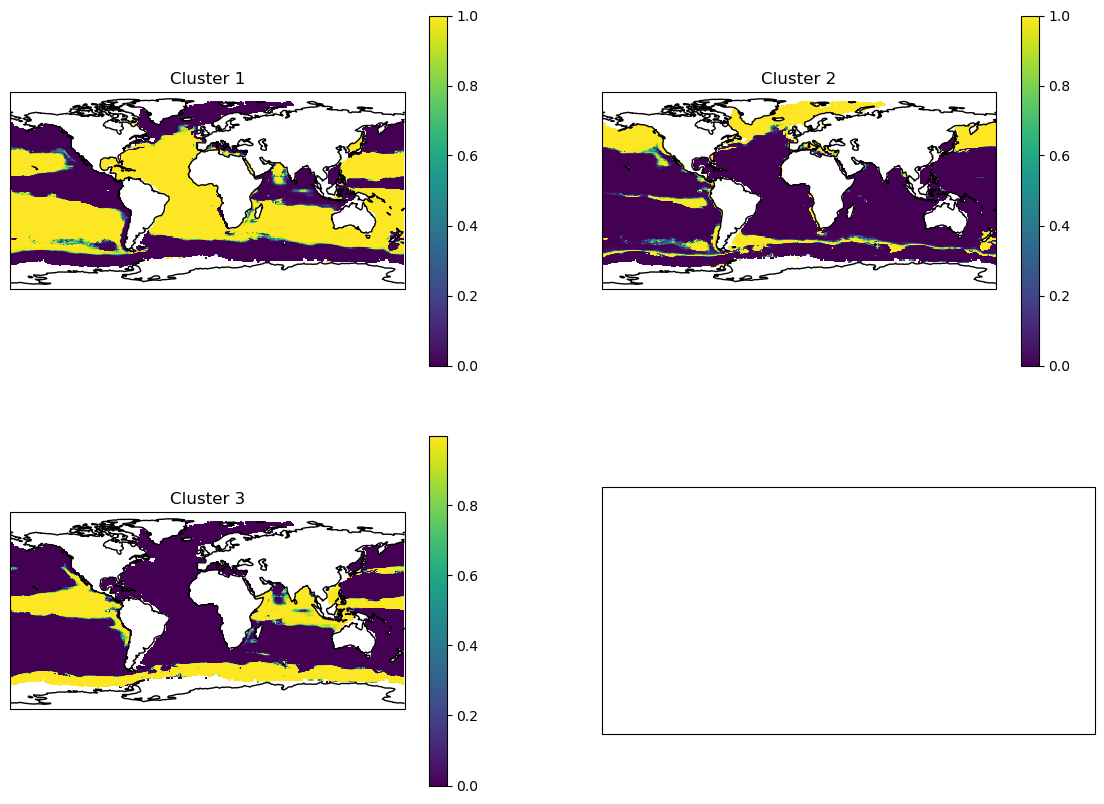

In [22]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Configuration de la figure avec des sous-graphiques en projection cartographique
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()

# Affichage des résultats de clustering
for i, ax in enumerate(axes):
    cluster_index = i + 1  # Clusters sont 1-indexés
    data = ds['prob'].sel(n_clusters=cluster_index)

    # Ajouter les lignes de côte pour référence
    ax.coastlines()
    ax.set_global()
    im = ax.pcolormesh(ds['xt_ocean'], ds['yt_ocean'], data, transform=ccrs.PlateCarree())

    # Titre pour chaque subplot
    ax.set_title(f'Cluster {cluster_index}')
    # Ajout d'une barre de couleur pour les probabilités
    plt.colorbar(im, ax=ax, orientation='vertical')

plt.tight_layout()
plt.show()



/home/svivier/.conda/envs/sebpy/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1785: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = super().pcolormesh(*args, **kwargs)


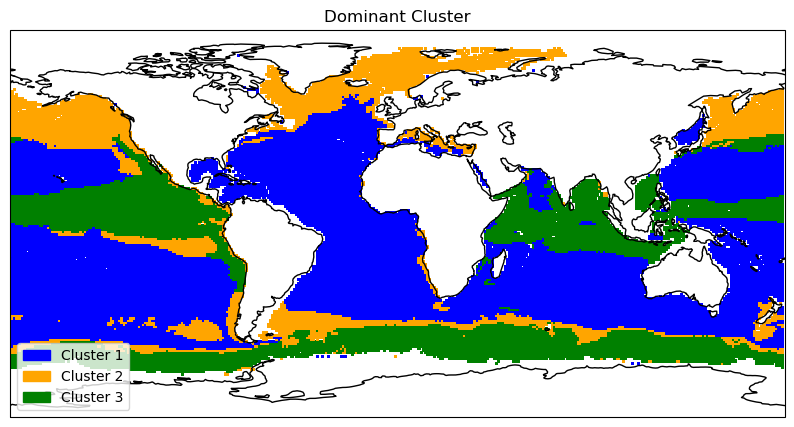

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
from matplotlib.colors import ListedColormap  # Correct import for ListedColormap

# Configuration de la figure avec une projection cartographique
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_global()
ax.coastlines()

# Calcul du cluster dominant à chaque point, avec gestion des NaN
clean_prob = ds['prob'].fillna(-np.inf)  # Remplacer NaN par -inf
dominant_cluster = clean_prob.argmax(dim='n_clusters') +1  # +1 pour l'indexation à partir de 0

# Gérer le cas où toute une tranche est NaN
dominant_cluster = dominant_cluster.where((clean_prob != -np.inf).any(dim='n_clusters'), np.nan)

# Créer une colormap personnalisée pour les clusters
colors = ['blue', 'orange', 'green']  # Bleu pour 1, Orange pour 2, Vert pour 3
cmap = ListedColormap(colors[:int(np.nanmax(dominant_cluster.values))])  # Utilisation des couleurs spécifiées

# Affichage des clusters dominants
im = ax.pcolormesh(ds['xt_ocean'], ds['yt_ocean'], dominant_cluster, cmap=cmap, transform=ccrs.PlateCarree())

# Créer la légende adaptée
legend_handles = [
    mpatches.Patch(color=color, label=f'Cluster {i+1}') for i, color in enumerate(colors)
]
ax.legend(handles=legend_handles, loc='lower left')  # Ajuster la position selon les besoins

# Titre de la figure
ax.set_title('Dominant Cluster')

# Enregistrement de la figure en PDF
plt.savefig('GMM.pdf')

plt.show()


In [24]:
cluster_df = dominant_cluster.to_dataframe(name='Cluster').reset_index()

# Fusionner les DataFrames sur la latitude et la longitude
df = pd.merge(df_pivoted, cluster_df, left_on=['Latitude', 'Longitude'], right_on=['yt_ocean', 'xt_ocean'], how='left')

# Afficher le DataFrame résultant
df


Latitude  Longitude       FG1       FG2       FG3       FG4       FG5  \
0         -70.5     -100.5  0.006534  0.014834  0.117279  0.287715  0.392746   
1         -70.5      -80.5  0.008183  0.017679  0.143197  0.295800  0.523208   
2         -70.5      -79.5  0.007867  0.017280  0.135653  0.275282  0.551982   
3         -69.5     -116.5  0.005675  0.013650  0.119472  0.279418  0.388943   
4         -69.5     -115.5  0.005923  0.013423  0.117270  0.280265  0.380013   
...         ...        ...       ...       ...       ...       ...       ...   
32310      81.5       50.5  0.041405  0.031865  0.216687  0.453447  0.607889   
32311      81.5       51.5  0.041827  0.031696  0.201767  0.451078  0.678046   
32312      81.5       52.5  0.041370  0.032609  0.205782  0.456194  0.752553   
32313      81.5       53.5  0.041184  0.032092  0.209477  0.431548  0.624091   
32314      81.5       54.5  0.042023  0.031536  0.196488  0.385530  0.638001   

            FG6       FG7       FG8       FG9  yt_ocean  xt_ocean  Cluster  
0      0.169135  0.059997  0.051836  0.028021     -70.5    -100.5      3.0  
1      0.118449  0.062552  0.051571  0.024553     -70.5     -80.5      2.0  
2      0.105991  0.063683  0.054258  0.024805     -70.5     -79.5      2.0  
3      0.181260  0.052188  0.043765  0.018479     -69.5    -116.5      3.0  
4      0.187280  0.050567  0.041910  0.018288     -69.5    -115.5      3.0  
...         ...       ...       ...       ...       ...       ...      ...  
32310  0.545341  0.063999  0.087408  0.027904      81.5      50.5      2.0  
32311  0.547239  0.064448  0.081432  0.024805      81.5      51.5      2.0  
32312  0.560078  0.063095  0.074338  0.022025      81.5      52.5      2.0  
32313  0.559038  0.061342  0.089464  0.023417      81.5      53.5      2.0  
32314  0.566637  0.063141  0.086751  0.025853      81.5      54.5      2.0  

[32315 rows x 14 columns]

In [25]:
import pandas as pd
import matplotlib.pyplot as plt



fg_traits = {
    'FG1': {'size': 1.10, 'myelination': 'Myelinated', 'spawning': 'Sac-spawning', 'nutrition': 'herbivores', 'feeding': 'cruise'},
    'FG3': {'size': 0.80, 'myelination': 'Amyelinated', 'spawning': 'Sac-spawning', 'nutrition': 'detritivores', 'feeding': 'cruise'},
    'FG4': {'size': 2.61, 'myelination': 'Myelinated', 'spawning': 'Free-spawning', 'nutrition': 'detritivores', 'feeding': 'current'},
    'FG5': {'size': 4.58, 'myelination': 'Myelinated', 'spawning': 'Sac-spawning', 'nutrition': 'carnivores', 'feeding': 'cruise'},
    'FG6': {'size': 6.80, 'myelination': 'Myelinated', 'spawning': 'Free-spawning', 'nutrition': 'herbivores', 'feeding': 'current'},
    'FG7': {'size': 1.80, 'myelination': 'Myelinated', 'spawning': 'Free-spawning', 'nutrition': 'herbivores', 'feeding': 'current'},
    'FG8': {'size': 3.40, 'myelination': 'Amyelinated', 'spawning': 'Free-spawning', 'nutrition': 'omnivores', 'feeding': 'ambush'},
    'FG9': {'size': 2.76, 'myelination': 'Amyelinated', 'spawning': 'Free-spawning', 'nutrition': 'omnivores', 'feeding': 'current'},
    'FG2': {'size': 1.10, 'myelination': 'Amyelinated', 'spawning': 'Sac-spawning', 'nutrition': 'omnivores', 'feeding': 'ambush'}
}

results = []

for cluster, group in df.groupby('Cluster'):
    statistics = {
        'Cluster': cluster,
        'Median size': 0,
        'Proportion of myelinated': 0,
        'Proportion of sac spawning': 0,
        'Proportion of carnivores': 0,
        'Proportion of herbivores': 0,
        'Proportion of detritivores': 0,
        'Proportion of omnivores': 0,
        'Proportion of ambush feeders': 0,
        'Proportion of current feeders': 0,
        'Proportion of cruise feeders': 0
    }
    total_biomass = 0
    for fg, traits in fg_traits.items():
        biomass = group[fg].sum()
        total_biomass += biomass
        statistics['Median size'] += traits['size'] * biomass
        statistics['Proportion of myelinated'] += (traits['myelination'] == 'Myelinated') * biomass
        statistics['Proportion of sac spawning'] += (traits['spawning'] == 'Sac-spawning') * biomass
        statistics['Proportion of ' + traits['nutrition']] += biomass
        statistics['Proportion of ' + traits['feeding'] + ' feeders'] += biomass

    if total_biomass > 0:
        for key in statistics.keys():
            if key != 'Cluster':
                statistics[key] /= total_biomass

    results.append(statistics)

results_df = pd.DataFrame(results)
results_df

Cluster  Median size  Proportion of myelinated  Proportion of sac spawning  \
0      1.0     3.403113                  0.642447                    0.363555   
1      2.0     3.809350                  0.779344                    0.498862   
2      3.0     3.827007                  0.780118                    0.430316   

   Proportion of carnivores  Proportion of herbivores  \
0                  0.182435                  0.298982   
1                  0.341839                  0.252836   
2                  0.313666                  0.242674   

   Proportion of detritivores  Proportion of omnivores  \
0                    0.264257                 0.254325   
1                    0.307848                 0.097477   
2                    0.315703                 0.127957   

   Proportion of ambush feeders  Proportion of current feeders  \
0                      0.219161                       0.461717   
1                      0.075946                       0.442392   
2                      0.095556                       0.491398   

   Proportion of cruise feeders  
0                      0.319122  
1                      0.481662  
2                      0.413046

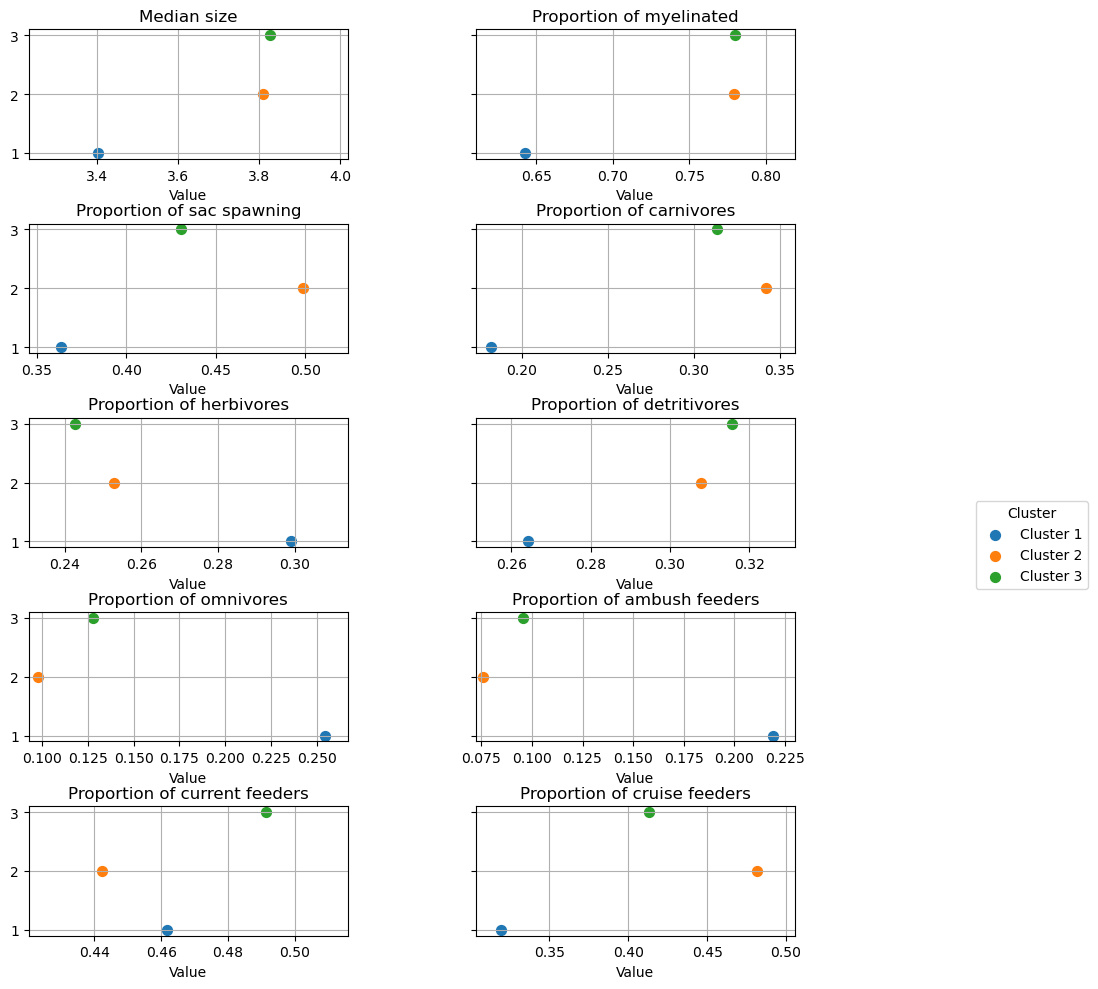

In [26]:
import matplotlib.pyplot as plt

# List of traits to plot
traits = [
    'Median size', 'Proportion of myelinated', 'Proportion of sac spawning',
    'Proportion of carnivores', 'Proportion of herbivores', 'Proportion of detritivores',
    'Proportion of omnivores', 'Proportion of ambush feeders', 'Proportion of current feeders',
    'Proportion of cruise feeders'
]

# Setup figure and axes for subplots with a tighter layout
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10, 10), sharey='row')  # Adjusted for a more compact presentation
axes = axes.flatten()

# Store legend handles
handles, labels = None, None

# Loop through each trait and create a scatter plot
for index, trait in enumerate(traits):
    ax = axes[index]
    # Get unique clusters and convert them to integers
    cluster_labels = results_df['Cluster'].unique()
    y_positions = range(len(cluster_labels))
    cluster_labels = [int(cluster) for cluster in cluster_labels]  # Convert cluster labels to integers

    for i, cluster in enumerate(cluster_labels):
        cluster_data = results_df[results_df['Cluster'] == cluster]
        scatter = ax.scatter(cluster_data[trait], [i] * len(cluster_data), label=f'Cluster {cluster}', s=50)
    
    ax.set_title(trait)
    ax.set_yticks(y_positions)  # Set y-ticks to integer cluster labels
    ax.set_yticklabels(cluster_labels)
    ax.set_xlabel('Value')
    ax.grid(True)
    
    # Optionally, auto-scale x-axis based on the data
    ax.autoscale(enable=True, axis='x', tight=True)
    
    # Add a small buffer to the x-axis limits
    xlim = ax.get_xlim()
    ax.set_xlim(xlim[0] - 0.05 * abs(xlim[0]), xlim[1] + 0.05 * abs(xlim[1]))

    # Get handles and labels for legend
    if index == 0:  # Get handles and labels only from the first subplot for consistency
        handles, labels = ax.get_legend_handles_labels()

# Place a single legend outside the right side of the subplots
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.1, 0.5), title='Cluster')

plt.tight_layout()
plt.subplots_adjust(right=0.8, hspace=0.5, wspace=0.4)  # Adjust the right space to fit the legend, and spacing

# Save the figure
plt.savefig('cluster_traits_comparison.pdf', format='pdf', bbox_inches='tight')
plt.show()
